# Delayed Acceptance example: Predator/Prey model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [2]:
np.random.seed(987)

In [21]:
class PredatorPreyModel:
    def __init__(self, datapoints, method):
        
        # set the timesteps, where we are collecting the model output
        self.datapoints = datapoints
        
        # set the span of the integration.
        self.t_span = [0, self.datapoints[-1]]
        
        # set the integration method
        self.method = method
        
    def dydx(self, t, y, a, b, c, d):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):
        
        # extract the parameters, and take the exponential to keep them positive
        P_0, Q_0, a, b, c, d = np.exp(parameters)
        
        # solve the initial value problem.
        self.y = solve_ivp(lambda t, y: self.dydx(t, y, a, b, c, d), self.t_span, np.array([P_0, Q_0]), t_eval=self.datapoints, method=self.method) 
        
        # return the results, only if the integration succeeded.
        if self.y.success:
            return self.y.y.flatten(), True
        else:
            return np.zeros_like(self.y.y.flatten()), False


### Define the predator/prey model
We use scipy.integrate.solve_ivp to solve the predator-prey model. The method `dydx` is the differential equation.

### Set up the true model

In [22]:
# #set the true parameters
P_0 = 10
Q_0 = 5
a = 1.0
b = 0.3
c = 0.2
d = 1.0

# collect the parameters in a vector and take the logarithm. 
# we sample the log of the parameters and take the exponential
# inside the model to keep the parameters positive.
true_parameters = np.log(np.array([P_0, Q_0, a, b, c, d]))

# set the integration points.
t_span = [0,12]
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

# initalise the true model and solve it
my_model = PredatorPreyModel(t_eval, method='Radau')
y_true = my_model(true_parameters)[0]

In [23]:
y_true*0

array([0., 0., 0., ..., 0., 0., 0.])

### Set up the forward models

In [24]:
n_data = 25 # number of datapoints
t_eval_data = np.linspace(t_span[0], t_span[1], n_data) # datapoints

# fine model
my_fine_model = PredatorPreyModel(t_eval_data, method='Radau') # initialise model

# coarse model
my_coarse_model = PredatorPreyModel(t_eval_data, method='RK45') # initialise model

### Generate data

In [25]:
# set the noise level
sigma = 1.0

noise = np.random.normal(scale=sigma, size=(t_eval_data.size,2)) # fine noise
data = my_fine_model(true_parameters)[0] + np.hstack((noise[:,0], noise[:,1])) # noisy fine data.
data[data < 0] = 0 # make sure all the data is positive.

### Plot the true model and the data

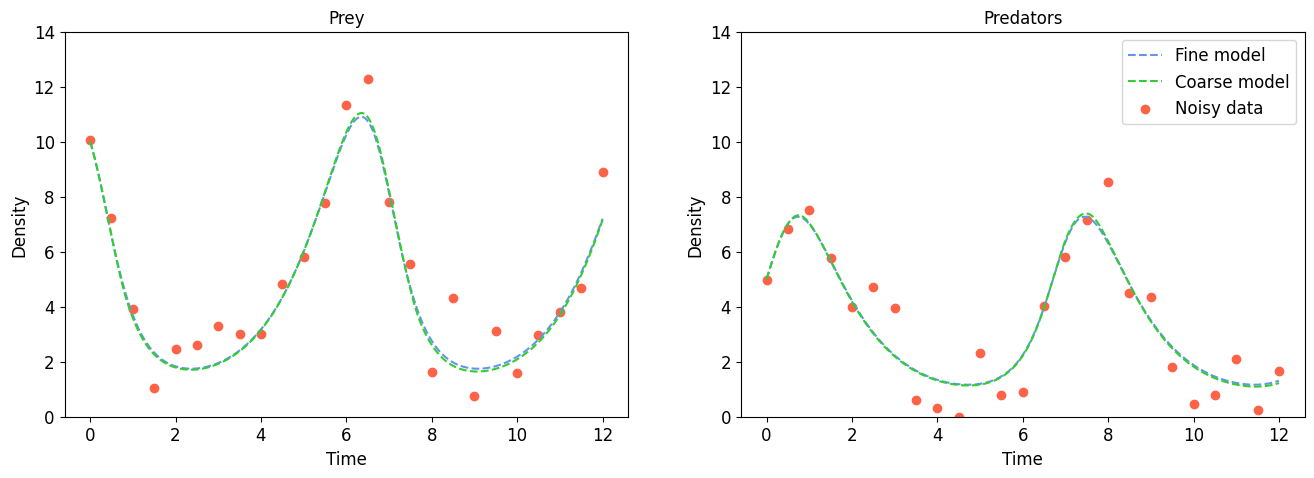

In [26]:
y_coarse = PredatorPreyModel(t_eval, method='RK45')(true_parameters)[0]
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true[:n_eval], '--', color='cornflowerblue')
axes[0].plot(t_eval, y_coarse[:n_eval], '--', color='limegreen')
axes[0].scatter(t_eval_data, data[:n_data], color='tomato')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
#axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true[n_eval:], '--', color='cornflowerblue', label='Fine model')
axes[1].plot(t_eval, y_coarse[n_eval:], '--', color='limegreen', label='Coarse model')
axes[1].scatter(t_eval_data, data[n_data:], color='tomato', label='Noisy data')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

plt.show()

### Set up the statistical model  and draw some samples from the prior
We need a fairly well-informed prior, since the model is nonlinear and the data is quite noisy. Hence, we assume that we have pretty good knowledge about the birth- and death rates of the prey and predators, respectively. The predation rate and the growth rate for the predators are left to be fairly uncertain.

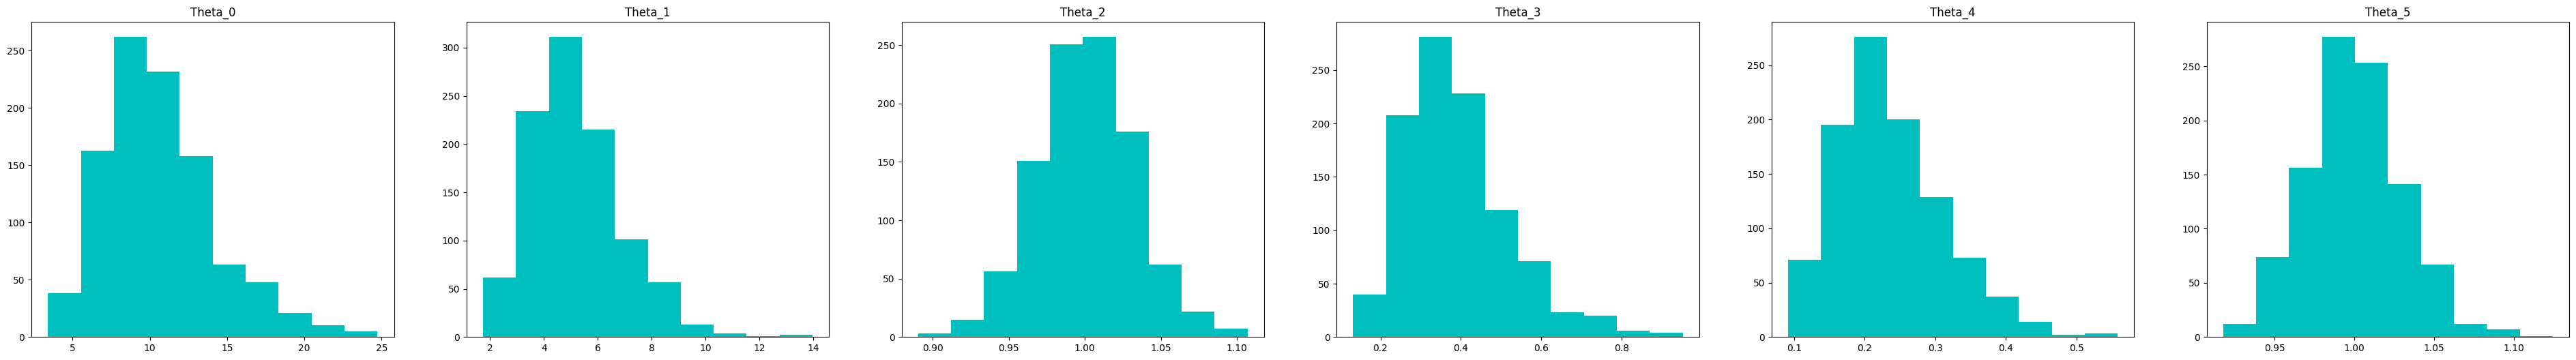

In [27]:
# prior distribution
mean_prior = np.array([np.log(data[0]), np.log(data[n_data]), 0, -1, -1.5, 0])
cov_prior = np.diag([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])
my_prior = stats.multivariate_normal(mean_prior, cov_prior)

# draw some samples and plot them
prior_samples = np.exp(my_prior.rvs(1000))
fig, axes = plt.subplots(nrows=1, ncols=my_prior.dim, figsize = (8*my_prior.dim, 6))
for i in range(my_prior.dim):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [28]:
# define the likelihood
cov_likelihood = sigma**2*np.eye(data.size)

my_loglike_fine = tda.GaussianLogLike(data, cov_likelihood)
my_loglike_coarse = tda.AdaptiveGaussianLogLike(data, cov_likelihood)

### Set up the link factories and get the MAP point

In [29]:
# set up the link factories
my_posterior_coarse = tda.Posterior(my_prior, my_loglike_coarse, my_coarse_model)
my_posterior_fine = tda.Posterior(my_prior, my_loglike_fine, my_fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]

In [30]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_posterior_fine)

### Set up the proposal

In [31]:
# random walk Metropolis
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Niconson
#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# Adaptive Metropolis
am_cov = np.eye(true_parameters.size)
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

### Sample

In [32]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 12000
    burnin = 2000

In [33]:
# initialise the chain
my_chain = tda.sample(my_posteriors, my_proposal, iterations=iterations, n_chains=2, initial_parameters=MAP, subchain_length=5, randomize_subchain_length=True, adaptive_error_model='state-independent')

2024-10-07 13:42:41,548	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.


Sampling 2 chains in parallel


### Diagnostics

In [35]:
idata = tda.to_inference_data(my_chain, level='fine', burnin=burnin)

In [37]:
import arviz as az

In [38]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,2.373,0.046,2.285,2.458,0.001,0.001,2351.0,3598.0,1.0
x1,1.591,0.088,1.426,1.755,0.002,0.001,2381.0,3730.0,1.0
x2,0.001,0.026,-0.050,0.048,0.001,0.000,2523.0,4268.0,1.0
x3,-1.210,0.057,-1.318,-1.108,0.001,0.001,2063.0,3628.0,1.0
x4,-1.648,0.049,-1.737,-1.554,0.001,0.001,2467.0,4045.0,1.0
x5,0.008,0.026,-0.038,0.059,0.001,0.000,2187.0,4262.0,1.0


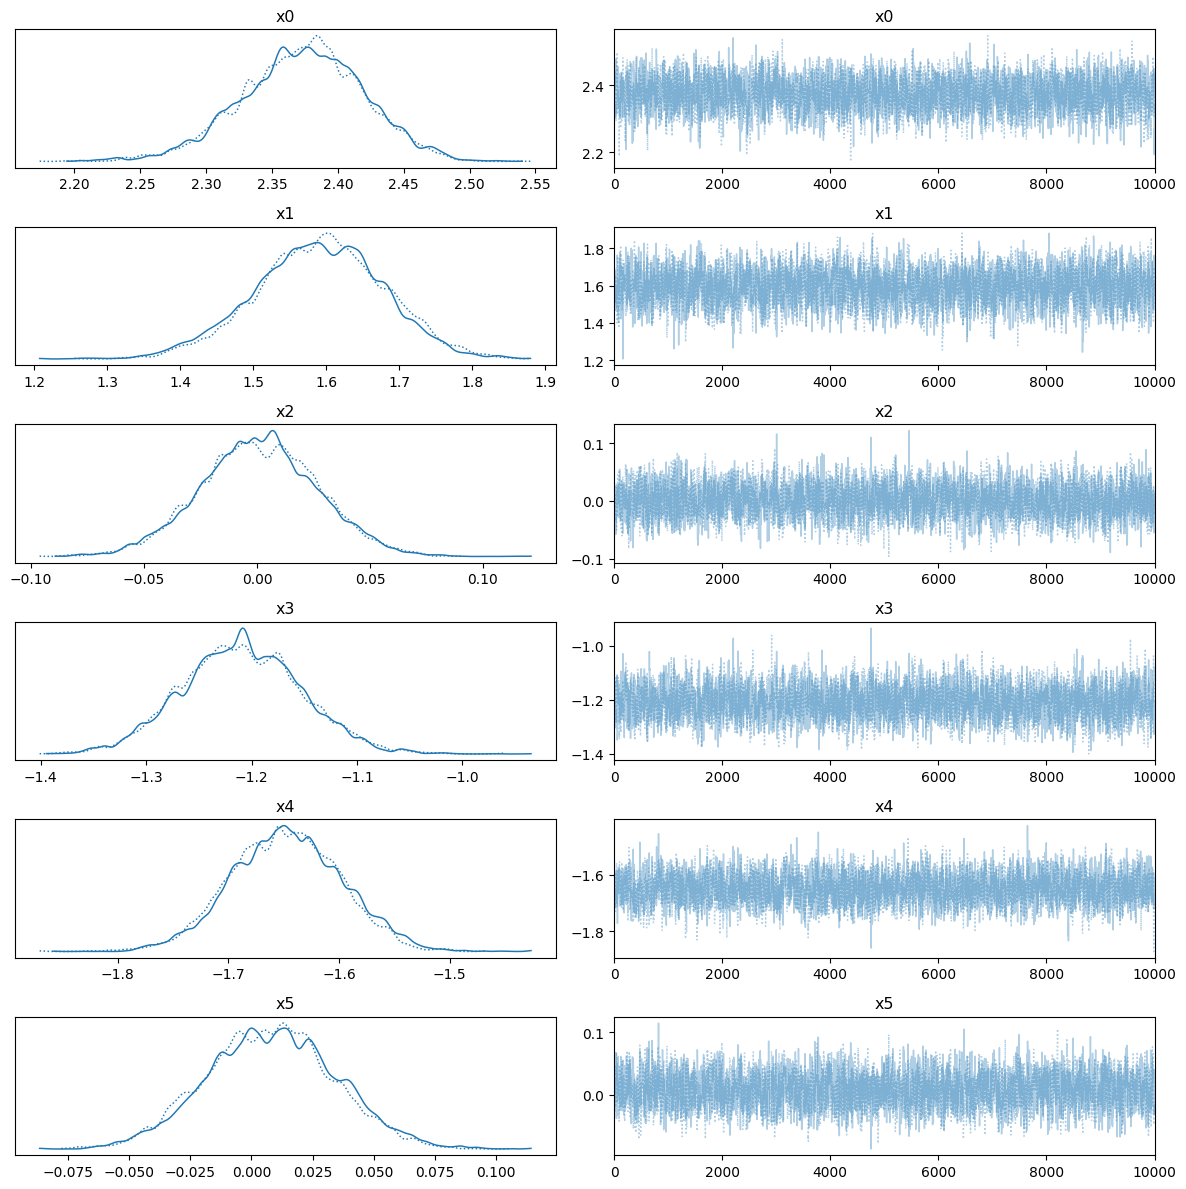

: 

In [39]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()